

---
# Test home exam 

Name: Pakcheera Choppradit

Data: Toxic Comment Classification Challenge
(https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)

---








**Setup**




In [ ]:
#import all package used in this document
import pandas as pd
import numpy as np
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
import pickle
from numpy import loadtxt
from keras.models import load_model
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from matplotlib_venn import venn3
stop_words = stopwords.words("english")
import sys

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Dowload data**

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/kaggle/toxic/train.csv")
final_test=pd.read_csv("/content/drive/MyDrive/kaggle/toxic/test.csv")
y=data.iloc[:,2:8]

# Explore and Clean Data

**Check the data have null value or not**

In [ ]:
data.isnull().values.any()

False

**Check imbalance**

In [ ]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(data[i].value_counts(),"\n")

0    144277
1     15294
Name: toxic, dtype: int64 

0    157976
1      1595
Name: severe_toxic, dtype: int64 

0    151122
1      8449
Name: obscene, dtype: int64 

0    159093
1       478
Name: threat, dtype: int64 

0    151694
1      7877
Name: insult, dtype: int64 

0    158166
1      1405
Name: identity_hate, dtype: int64 



 It show imbalanced dataset which have 0 more than 1.

**Check number of occurrences and multiple class**

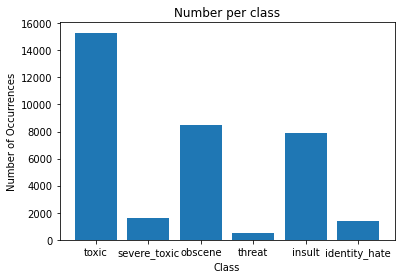

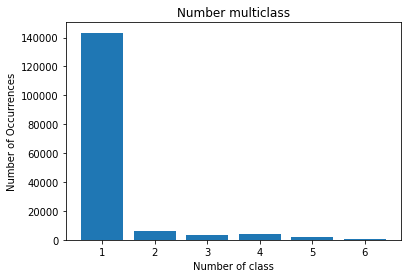

In [ ]:
plt.bar(['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],data[['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']].sum())
plt.title("Number per class")
plt.xlabel("Class")
plt.ylabel("Number of Occurrences")
data["number_of_class"]=data.sum(axis=1)
data["number_of_class"]=data["number_of_class"]+1
x=data["number_of_class"].value_counts()
plt.show()
plt.bar(x.index[0:-1],x.values[0:-1])
plt.title("Number multiclass")
plt.xlabel("Number of class")
plt.ylabel("Number of Occurrences")
plt.show()

Toxic, obscene and insuit is the major class of comment and mostly comment have 1 class.

**Venn diagram of 3 major class**

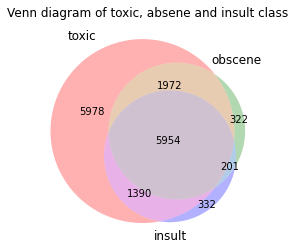

In [ ]:
Class=['toxic', 'obscene','insult']
S=[]
for i in range(0,3):
  s=  set(list(data[data[Class[i]]==1]["id"].values))
  S.append(s)
venn3(S,Class,alpha=0.3)
plt.title("Venn diagram of toxic, absene and insult class")
plt.show()

Obscene and insult mostly be the same comment and them have high probability to be toxic.

**Clean data**

Create the fucntion to clean data

In [ ]:
sys.setrecursionlimit(100000)
stemmer = nltk.porter.PorterStemmer()
def clean_text(x):

  #do lower case
  x = x.lower()

  #delete the word that have https, @, # and word in () 
  x = re.sub(r'http*\S+', '', x)
  x = re.sub(r'@\S+', '', x)
  x = re.sub(r'#\S+','', x)
  x = re.sub("\(.*?\)","",x)
  
  #remove punctuation
  x=re.sub(r'[^\w\s]','',x)
  
  #remove digit
  x = ''.join(i for i in x if not i.isdigit())

  # replece \n by " "
  x = x.replace("\n"," ")

  #delete stop word
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])

  x = ' '.join([stemmer.stem(word) for word in x.split()])
  return x

In [ ]:
data["clean_text"]=np.vectorize(clean_text)(data["comment_text"])

**Show the most commom word of each class**

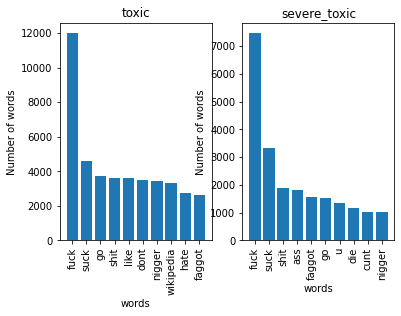

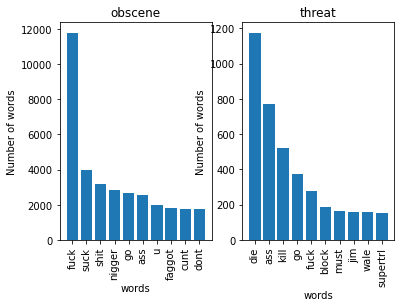

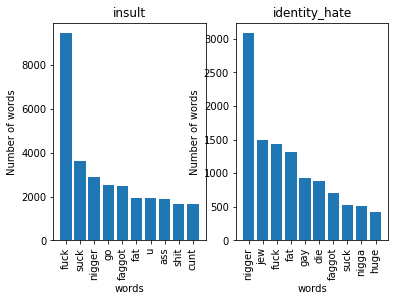

In [ ]:
C=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
for i in range(0,6):

  #choose the comment that the class be 1 
  word=data[data[C[i]]==1]["clean_text"].values

  #use Counter to count the word
  word=Counter(" ".join(word).split(" "))
  
  #choose 10 words that common
  word=word.most_common(10)
  vocab = [i[0] for i in word]
  number= [i[1] for i in word]
  if i%2==0:
    plt.subplot(1,2,1)
  else:
    plt.subplot(1,2,2)
  plt.bar(vocab,number)
  plt.xticks(rotation ='vertical')
  plt.title(C[i])
  plt.xlabel("words")
  plt.ylabel("Number of words")
  if i%2==1:
    plt.show()


There are many commom word that appear in more than 1 class. For example, fuck, shit, suck and die

**Count the len of each comment**

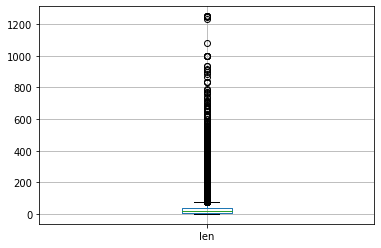

In [ ]:
def l(text):
  return len(text.split(' '))
data["len"]=np.vectorize(l)(data["clean_text"])
data.boxplot(column="len")

In [ ]:
data["len"].describe()

count    159571.000000
mean         32.796768
std          50.544385
min           1.000000
25%           8.000000
50%          17.000000
75%          36.000000
max        1250.000000
Name: len, dtype: float64

The variance of len's comment is very high

# Tf-idf Vectorizer

From exploring data, I see that the lenth of each comment is variance, so it is   not suitible to use bag of word. Therefore, I will use Tf-idf to preporcess data


**Tf-idf (term frequency–inverse document frequency)**

-**Term frequency**

There are 3 type of tf which are Term Frequency,Log Normalization and Double Normalization. I choose Double Normalization becuase it is suitable for text that have much different lenght.
Here is formula of Double Normalization

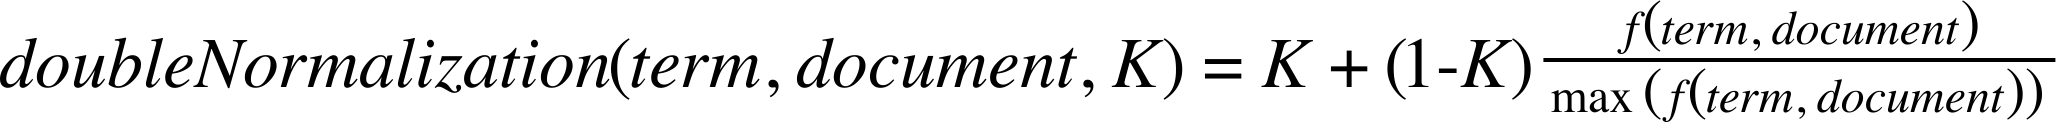

-**Inverse document frequency**

It is the number of all considered documents in relation to the number of documents that contain the that term 

Here is formula of idf

 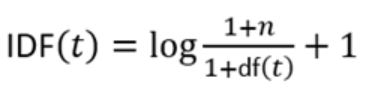

Finaly we can find Tf-idf by multipy them together.



In this I try number of gram to be 1,2 and 1-2. It is the lenght that we cut to be a term.

Example

"I love you"

1-gram: ["I","love","you"]

2-gram: ["I love","love you"]

1-2-gram:["I","love","you","I love","love you"]

In [ ]:
Tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_features=2500,ngram_range=(1,1))
Tfidf_vectorizer.fit(data['clean_text'])
Tfidf_vectorizer_x = Tfidf_vectorizer.transform(data['clean_text'])

In [ ]:
pickle.dump(Tfidf_vectorizer, open("/content/drive/MyDrive/kaggle/toxic/preprocess/Tfidf_vectorizer1.pickle", "wb"))

In [ ]:
Tfidf_vectorizer2 = TfidfVectorizer(stop_words="english",max_features=2500,ngram_range=(2,2))
Tfidf_vectorizer2.fit(data['clean_text'])
Tfidf_vectorizer_x2 = Tfidf_vectorizer.transform(data['clean_text'])

In [ ]:
pickle.dump(Tfidf_vectorizer, open("/content/drive/MyDrive/kaggle/toxic/preprocess/Tfidf_vectorizer2.pickle", "wb"))

In [ ]:
Tfidf_vectorizer1_2 = TfidfVectorizer(stop_words="english",max_features=2500,ngram_range=(1,2))
Tfidf_vectorizer1_2.fit(data['clean_text'])
Tfidf_vectorizer_x1_2 = Tfidf_vectorizer.transform(data['clean_text'])

In [ ]:
pickle.dump(Tfidf_vectorizer, open("/content/drive/MyDrive/kaggle/toxic/preprocess/Tfidf_vectorizer1_2.pickle", "wb"))

# Machine Learning

For machine learning, I choose three model which is logistic regression, decision tree and random forest. This  will be run in different gram to compare which model with which number of gram be the best.



*   Logistic regression
*   Decision tree 
*   Random forest







**Create the function to fit the model**

becaues there are 6 columns to predict and it is multclass. In machine learning, I have to create the model separately and combine it later.

In [ ]:
def k_folk_cv(clf,X,y,k):
  Auc=[]
  # do loop to create model in each class
  for i in range(0,6):
    Auc.append(sum(cross_val_score(clf,X,y.iloc[:,i],scoring="roc_auc",cv=k))/k)
  return Auc

**1 gram**

In [ ]:
LG=k_folk_cv(LogisticRegression(),Tfidf_vectorizer_x,y,5)
DT=k_folk_cv(DecisionTreeClassifier(max_depth=10),Tfidf_vectorizer_x,y,5)
RF=k_folk_cv(RandomForestClassifier(max_depth=10),Tfidf_vectorizer_x,y,5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print("roc_auc of LogisticRegression : ",sum(LG)/len(LG))
print("roc_auc of DecisionTree : ",sum(DT)/len(DT),)
print("roc_auc of RandomForest : ",sum(RF)/len(RF))

roc_auc of LogisticRegression :  0.972821910549366
roc_auc of DecisionTree :  0.7861589811922479
roc_auc of RandomForest :  0.9593779129608534


**2-grame**

In [ ]:
LG=k_folk_cv(LogisticRegression(),Tfidf_vectorizer_x2,y,5)
DT=k_folk_cv(DecisionTreeClassifier(max_depth=10),Tfidf_vectorizer_x2,y,5)
RF=k_folk_cv(RandomForestClassifier(max_depth=10),Tfidf_vectorizer_x2,y,5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print("roc_auc of LogisticRegression : ",sum(LG)/len(LG))
print("roc_auc of DecisionTree : ",sum(DT)/len(DT),)
print("roc_auc of RandomForest : ",sum(RF)/len(RF))

roc_auc of LogisticRegression :  0.972821910549366
roc_auc of DecisionTree :  0.7890962740385253
roc_auc of RandomForest :  0.9591694764966873


**1-2 grame**

In [ ]:
LG=k_folk_cv(LogisticRegression(),Tfidf_vectorizer_x1_2,y,5)
DT=k_folk_cv(DecisionTreeClassifier(max_depth=10),Tfidf_vectorizer_x1_2,y,5)
RF=k_folk_cv(RandomForestClassifier(max_depth=10),Tfidf_vectorizer_x1_2,y,5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print("roc_auc of LogisticRegression : ",sum(LG)/len(LG))
print("roc_auc of DecisionTree : ",sum(DT)/len(DT),)
print("roc_auc of RandomForest : ",sum(RF)/len(RF))

roc_auc of LogisticRegression :  0.972821910549366
roc_auc of DecisionTree :  0.7885062020666685
roc_auc of RandomForest :  0.9593765086900183


Logistic regression get the best score and  number of gram is not effect the performance. For decision tree the performance is not good, but adding number of gram and combine 1-2 gram get better result. For random forest, 2 gram is best performance of it. however, it is not good as logistic regression.

# GridsearchCV

This method is finding the optimal roc_auc when get differents hyperparameter and also do k folk varidation to prevent bias of data.

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
parameter=[]
for i in range(0,6):
    clf = LogisticRegression()
    grid_values = {'penalty': ['l2'],'C': [0.001, 0.01, 0.1, 1, 10,25],'solver':[ 'lbfgs', 'liblinear', 'sag', 'saga']}

    #gridsearchCV with optimal roc_auc
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = "roc_auc",cv=5,refit = True,verbose = 1)
    grid_clf_acc.fit(Tfidf_vectorizer_x,y.iloc[:,i])
    print("tuned hpyerparameters :(best parameters) ",grid_clf_acc.best_params_)
    print("accuracy :",grid_clf_acc.best_score_)

    #collect best parameter
    parameter.append(grid_clf_acc.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
accuracy : 0.9598195791668764
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
accuracy : 0.9827250194295054
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
accuracy : 0.9766396987652511
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
accuracy : 0.9790115168962489
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
accuracy : 0.9690135161867897
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
accuracy : 0.9698489073508915


After I get hyperparameter, I do the model again and collect model to predict in the future.

In [ ]:
model=[]
X_train, X_test, y_train, y_test = train_test_split(Tfidf_vectorizer_x,y, train_size=0.8)
Auc=[]
for i in range(0,6):
    
    #defind hyperparameter then fit it and collect modelto the list
    clf = LogisticRegression(C=parameter[i]["C"],penalty=parameter[i]["penalty"],solver=parameter[i]["solver"])
    clf.fit(X_train, y_train.iloc[:,i])
    model.append(clf)
    
    # predict test data
    predicted = model[i].predict_proba(X_test)

    #predict_proba will get 2 values (probability to be 0 and 1) so I have to choose just the probaility to be 1 
    predicted=predicted[:,1]

    #here is method to combine each predicted column
    if i==0:
        prep=[predicted]
    else:
        prep=np.append(prep, [predicted], axis=0)
        
    #calculate roc_auc_score
    Auc.append(roc_auc_score(y_test.iloc[:,i], predicted))
print(sum(Auc)/len(Auc))

0.9737057952660879


The GridsearchCV imporve rou_auc around 0,001.

# Kaggle Test dataset (ML)

After I get hyperparameter of logistic regression and fit the model.I use that model in unseen data from kaggle to measure the permance.

In [ ]:
#clean data and fit data on Tf-idf to get the same format of training data.
final_test["clean_text"]=np.vectorize(clean_text)(final_test["comment_text"])
Tfidf_vectorizer_x = Tfidf_vectorizer.transform(final_test['clean_text'])

In [ ]:
for i in range(0,6):
    #predict probability that will occur in each class
    predicted = model[i].predict_proba(Tfidf_vectorizer_x)
    #Choose the probability to be 1
    predicted=predicted[:,1]

    #combine each class result
    if i==0:
        prep=[predicted]
    else:
        prep=np.append(prep, [predicted], axis=0)

In [ ]:
# save result on dataframe
sub=pd.DataFrame(prep.T,columns=y.columns)

In [ ]:
#add id on dataframe
sub=pd.concat([final_test[["id"]],sub],axis=1)

In [ ]:
#set id to be index
sub=sub.set_index('id')

In [ ]:
#save the result on csv file
sub.to_csv("/content/drive/MyDrive/kaggle/toxic/submit_ml.csv")

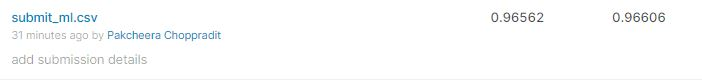

Here is the result on kaggle website

# Bidirection LSTM

It is improve version of lstm to combine to lstm in forward and backward layer.

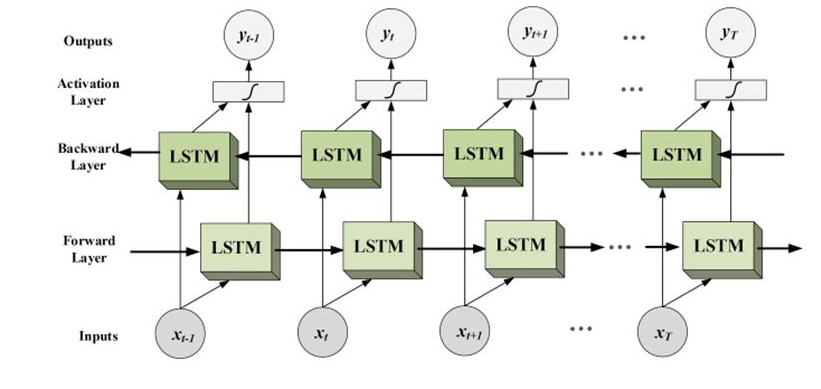

In [ ]:
# defind the value of max words and max len
max_words = 10000
max_len = 500

# get tokenizer that find max_words 
tok = Tokenizer(num_words=max_words)

#split train test data
X_train, X_test, y_train, y_test = train_test_split(data["clean_text"].values,y, test_size=0.2)

#fit on data and get sequences to pad sequenes 
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

#do the same as train data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
# create the modelEmbidding, bidirectional LSTM and Dense 50 withe relu activation and the output is 6 node with sigmoid activation

embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(LSTM(50, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# use adam optimizer with learning rate = 0.01
opt = keras.optimizers.Adam(learning_rate=0.01)

#use bunary_crossentrory that suitable of binary class data
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# show summary od model
print(model.summary())

#fit and save mode in file path
history=model.fit(sequences_matrix, y_train, epochs=1, batch_size=512,validation_split=0.2,verbose=1)
scores = model.evaluate(test_sequences_matrix, y_test, verbose=1)
filepath = "/content/drive/MyDrive/kaggle/toxic/LSTM/toxic_LSTM_dropout_best.h5"
model.save(filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 3,145,756
Trainable params: 3,145,756
Non-trainable params: 0
_________________________________________________________________
None
998/998 [==============================] - 94s 94ms/step - loss: 0.0511 - accuracy: 0.9937


It get high performance in just 1 epochs and when I add the number of epoch the val_loss is increase that is the overfit sign so I dojust 1 epoch.

# Kaggle test dataset (Bidirectional LSTM)

Test the model on kaggle test dataset

In [ ]:
#clean the test dataset
final_test["clean_text"]=np.vectorize(clean_text)(final_test["comment_text"])

In [ ]:
#pad sequences of test data
final_test_sequences = tok.texts_to_sequences(final_test["clean_text"])
final_test_sequences_matrix = sequence.pad_sequences(final_test_sequences,maxlen=max_len)

In [ ]:
#load the model that fit before and make predic
model = load_model('/content/drive/MyDrive/kaggle/toxic/LSTM/toxic_LSTM_dropout_best.h5')
print(model.summary())
predicted = model.predict(final_test_sequences_matrix,verbose=1,batch_size=512)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               140400    
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 3,145,756
Trainable params: 3,145,756
Non-trainable params: 0
_________________________________________________________________
None
300/300 [==============================] - 192s 580ms/step


In [ ]:
#save prediction on dataframe
sub=pd.DataFrame(predicted,columns=y.columns)

In [ ]:
sub=pd.concat([final_test[["id"]],sub],axis=1)

In [ ]:
sub=sub.set_index('id')

In [ ]:
#save on file path
sub.to_csv("/content/drive/MyDrive/kaggle/toxic/submit_lstm_dropout_best.csv")

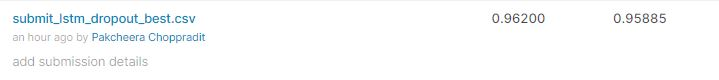

Here is the result of test dataset 

# Average the result of ML and Birectional LSTM

Now I have model of machine learining (logistic regression) and birectional lstm to improve the performance is average the result of both model

In [ ]:
sub_ml=pd.read_csv("/content/drive/MyDrive/kaggle/toxic/submit_ml.csv",index_col=["id"])
sub_lstm=pd.read_csv("/content/drive/MyDrive/kaggle/toxic/submit_lstm_dropout_best.csv",index_col=["id"])

In [ ]:
submit=(sub_ml[sub_ml.columns]+sub_lstm[sub_lstm.columns])/2

In [ ]:
submit.to_csv("/content/drive/MyDrive/kaggle/toxic/submit_lstm_ml.csv")

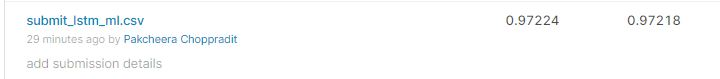

Here is the result of combine two model. the reason why the performance is better is each mpdel can be professional different kind of data so combine them will get the advantage of each model that will get better performance.